# Stochastic Volatility model

In [2]:
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk

from scipy.sparse import csc_matrix
from scipy import optimize

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, Hoffman (2011) p21.

$$ \sigma \sim Exponential(50) $$

$$ \nu \sim Exponential(.1) $$

$$ s_i \sim Normal(s_{i-1}, \sigma^{-2}) $$

$$ log(\frac{y_i}{y_{i-1}}) \sim t(\nu, 0, exp(-2 s_i)) $$

Here, $y$ is the daily return series and $s$ is the latent log volatility process.

## Build Model

First we load some daily returns of the S&P 500.

In [3]:
n = 400
returns = np.genfromtxt("../data/SP500.csv")[-n:]
returns[:5]

array([-0.00637 , -0.004045, -0.02547 ,  0.005102, -0.047733])

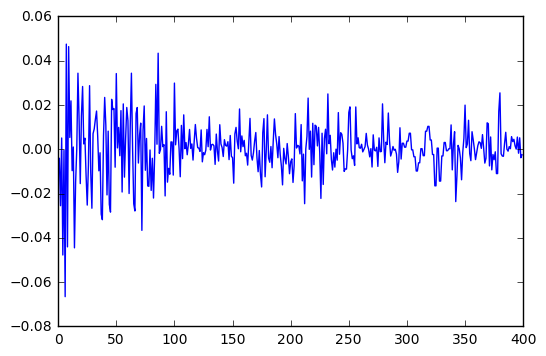

In [4]:
plt.plot(returns)

Specifying the model in pymc3 mirrors its statistical specification. 

In [5]:
model = pm.Model()
with model:
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)

    nu = pm.Exponential('nu', 1./10)
    s = GaussianRandomWalk('s', sigma**-2, shape=n)

    r = pm.StudentT('r', nu, lam=pm.math.exp(-2*s), observed=returns)

Applied log-transform to sigma and added transformed sigma_log_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.


## Fit Model

For this model, the full maximum a posteriori (MAP) point is degenerate and has infinite density. To get good convergence with NUTS we use ADVI (autodiff variational inference) for initialization. This is done under the hood by the `sample_init()` function.

In [6]:
with model:
    trace = pm.sample_init()

Initializing using advi...


Iteration 0 [0%]: ELBO = -2608.01
Iteration 50000 [10%]: Average ELBO = -5206.24
Iteration 100000 [20%]: Average ELBO = 1126.1
Iteration 150000 [30%]: Average ELBO = 1138.65
Iteration 200000 [40%]: Average ELBO = 1138.58
Iteration 250000 [50%]: Average ELBO = 1138.46
Iteration 300000 [60%]: Average ELBO = 1138.61
Iteration 350000 [70%]: Average ELBO = 1138.58
Iteration 400000 [80%]: Average ELBO = 1138.39
Iteration 450000 [90%]: Average ELBO = 1138.6


Sampling using nuts...


Finished [100%]: Average ELBO = 1138.68


100%|██████████| 2000/2000 [03:48<00:00, 13.95it/s]


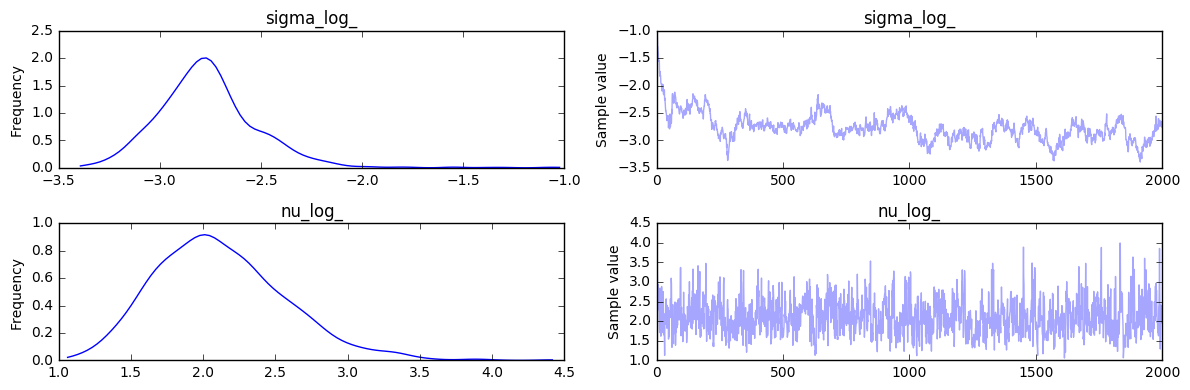

In [7]:
figsize(12,6)
pm.traceplot(trace, model.vars[:-1]);

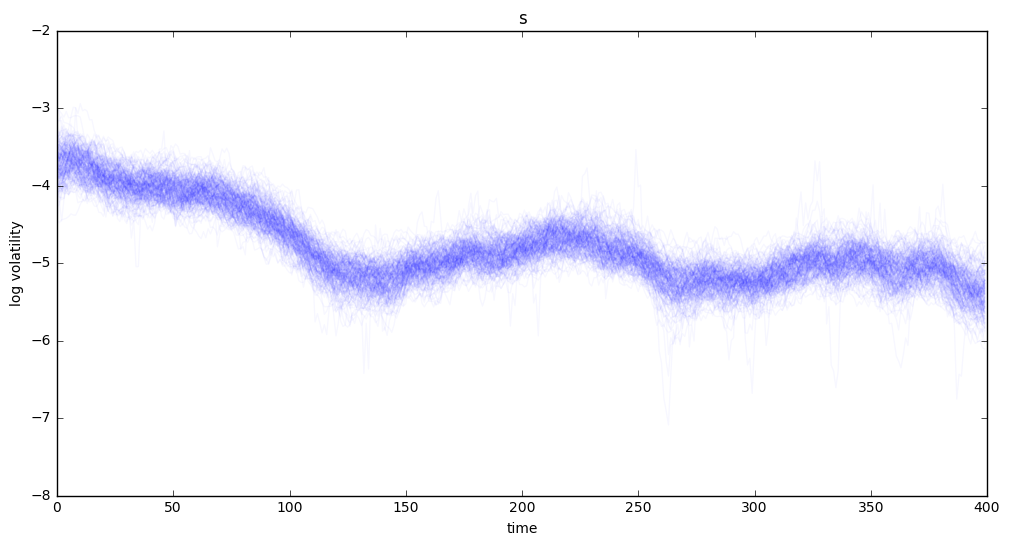

In [8]:
figsize(12,6)
title(str(s))
plot(trace[s][::10].T,'b', alpha=.03);
xlabel('time')
ylabel('log volatility')

Looking at the returns over time and overlaying the estimated standard deviation we can see how the model tracks the volatility over time.

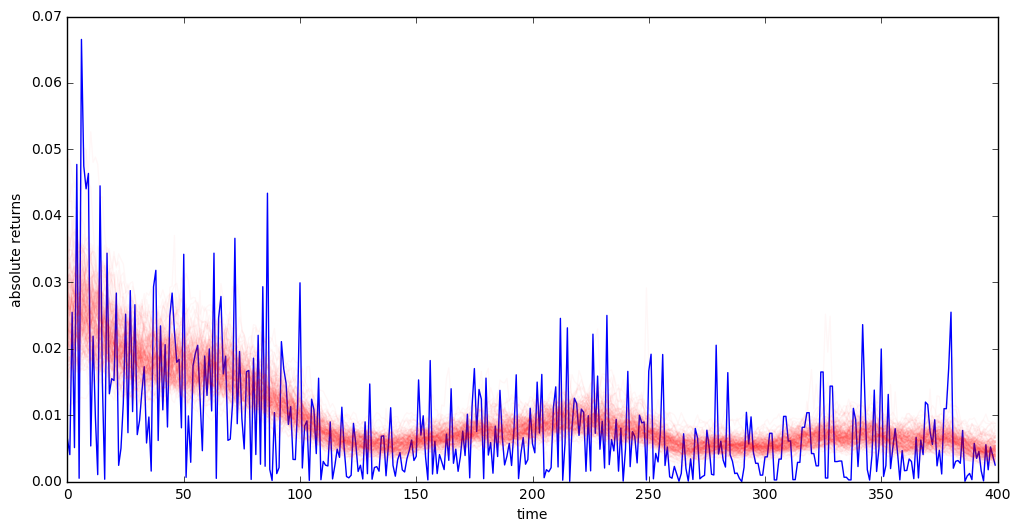

In [9]:
plot(np.abs(returns))
plot(np.exp(trace[s][::10].T), 'r', alpha=.03);
sd = np.exp(trace[s].T)
xlabel('time')
ylabel('absolute returns')

## References

1. Hoffman & Gelman. (2011). [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](http://arxiv.org/abs/1111.4246). 